In [7]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from scipy.special import j0, jn_zeros
from numpy.fft import rfft, rfftfreq

In [8]:
propiedades = {
    0: "lower x edge [m]",
    1: "upper x edge [m]",
    2: "lower y edge [m]",
    3: "upper y edge [m]",
    4: "cell volume [m3]",
    5: "density [kg/m3]",
    6: "velocity x [m/s]",
    7: "velocity y [m/s]",
    8: "temperature [eV]",
    9: "SDE [W/m3]",
    10: "P_therm [Pa]",
    11: "P_rad [Pa]",
    12: "P_total [Pa]",
    13: "internal energy [J/kg]",
    14: "cv [J/kg/K]",
    15: "rho*cv [J/m3/K]",
    16: "sound speed [m/s]",
    17: "charge state",
    18: "electron density [e/m3]",
    19: "kinetic energy",
    20: "nmat",
    21: "fvol 0",
    22: "fvol 1",
    23: "fvol 2",
    24: "fvol 3",
    25: "fvol 4",
    26: "fvrho 0",
    27: "fvrho 1",
    28: "fvrho 2",
    29: "fvrho 3",
    30: "fvrhoe 0",
    31: "fvrhoe 1",
    32: "fvrhoe 2",
    33: "fvrhoe 3"
}


In [9]:
def calcular_gradiente_total_2D_streaming(
    ruta_hdf5,
    indice_propiedad,
    dtype=np.float32
):
    """
    Calcula el módulo del gradiente total 2D:
    |∇f| = sqrt( (∂f/∂z)^2 + (∂f/∂r)^2 )
    usando streaming (memmap).
    """

    base = os.path.basename(ruta_hdf5)
    nombre = os.path.splitext(base)[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    ruta_prop = os.path.join(carpeta, f"prop_{indice_propiedad:02d}.npy")
    if not os.path.exists(ruta_prop):
        raise FileNotFoundError(ruta_prop)

    f = np.load(ruta_prop, mmap_mode="r")   # (Nt, Nz, Nr)
    Nt, Nz, Nr = f.shape

    ruta_out = os.path.join(
        carpeta,
        f"prop_{indice_propiedad:02d}_grad_total.npy"
    )

    grad_total = np.lib.format.open_memmap(
        ruta_out,
        mode="w+",
        dtype=dtype,
        shape=(Nt, Nz, Nr)
    )

    print("▶ Calculando gradiente total |∇f| en streaming...")
    for t in range(Nt):
        df_dz = np.gradient(f[t], axis=0)
        df_dr = np.gradient(f[t], axis=1)

        grad_total[t] = np.sqrt(df_dz**2 + df_dr**2)

        if t % 50 == 0:
            print(f"  t = {t}/{Nt}")

    del grad_total
    print("✔ Gradiente total guardado:", ruta_out)

    return ruta_out

def visualizar_gradiente_total_2D_seguro(
    ruta_hdf5,
    indice_propiedad,
    fps=10,
    formato="mp4"
):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.animation import FFMpegWriter
    import h5py, os

    base = os.path.basename(ruta_hdf5)
    nombre = os.path.splitext(base)[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    ruta_grad = os.path.join(
        carpeta,
        f"prop_{indice_propiedad:02d}_grad_total.npy"
    )

    if not os.path.exists(ruta_grad):
        raise FileNotFoundError(
            "Ejecuta primero calcular_gradiente_total_2D_streaming()"
        )

    grad = np.load(ruta_grad, mmap_mode="r")
    Nt, Nz, Nr = grad.shape

    # tiempos
    tiempos = []
    with h5py.File(ruta_hdf5, "r") as f:
        for obj in f.values():
            if "time" in obj.attrs:
                tiempos.append(obj.attrs["time"][0])
    tiempos = np.array(tiempos)
    if len(tiempos) != Nt:
        tiempos = np.arange(Nt, dtype=float)
    tiempos_ns = tiempos * 1e9

    # vmin/vmax robusto
    sample = np.linspace(0, Nt-1, min(50, Nt)).astype(int)
    vmin = min(np.percentile(grad[i], 2) for i in sample)
    vmax = max(np.percentile(grad[i], 98) for i in sample)

    nombre_prop = propiedades.get(
        indice_propiedad,
        f"prop_{indice_propiedad:02d}"
    )

    etiqueta = r"$|\nabla f|$"

    salida = os.path.join(
        carpeta,
        f"prop_{indice_propiedad:02d}_grad_total.{formato}"
    )

    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(
        grad[0],
        origin="lower",
        cmap="inferno",
        vmin=vmin,
        vmax=vmax
    )
    plt.colorbar(im, label=etiqueta)
    ax.set_xlabel("R [µm]")
    ax.set_ylabel("H [µm]")
    titulo = ax.set_title(
        f"{etiqueta} de {nombre_prop} | t = {tiempos_ns[0]:.3f} ns"
    )

    writer = FFMpegWriter(fps=fps)
    with writer.saving(fig, salida, dpi=150):
        for i in range(Nt):
            im.set_data(grad[i])
            titulo.set_text(
                f"{etiqueta} de {nombre_prop} | t = {tiempos_ns[i]:.3f} ns"
            )
            writer.grab_frame()
            if i % 50 == 0:
                print(f"Frame {i}/{Nt}")

    plt.close(fig)
    print("✔ Animación guardada:", salida)

def ver_gradiente_total_2D_por_indice(
    ruta_hdf5,
    indice_propiedad,
    t_index=0
):
    import numpy as np
    import matplotlib.pyplot as plt
    import h5py, os

    base = os.path.basename(ruta_hdf5)
    nombre = os.path.splitext(base)[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    ruta_grad = os.path.join(
        carpeta,
        f"prop_{indice_propiedad:02d}_grad_total.npy"
    )

    grad = np.load(ruta_grad, mmap_mode="r")
    Nt, Nz, Nr = grad.shape

    # tiempos
    tiempos = []
    with h5py.File(ruta_hdf5, "r") as f:
        for obj in f.values():
            if "time" in obj.attrs:
                tiempos.append(obj.attrs["time"][0])
    tiempos = np.array(tiempos)
    if len(tiempos) != Nt:
        tiempos = np.arange(Nt, dtype=float)
    tiempos_ns = tiempos * 1e9

    frame = grad[t_index]
    vmin, vmax = np.percentile(frame, [2,98])

    nombre_prop = propiedades.get(
        indice_propiedad,
        f"prop_{indice_propiedad:02d}"
    )

    plt.figure(figsize=(6,5))
    plt.imshow(frame, origin="lower", cmap="inferno",
               vmin=vmin, vmax=vmax)
    plt.colorbar(label=r"$|\nabla f|$")
    plt.xlabel("R [µm]")
    plt.ylabel("H [µm]")
    plt.title(
        rf"$|\nabla f|$ de {nombre_prop} | "
        rf"t = {tiempos_ns[t_index]:.3f} ns"
    )
    plt.tight_layout()
    plt.show()


In [13]:
def _indices_por_tiempos_ns(tiempos_s, tiempos_ns_obj):
    tiempos_ns = tiempos_s.astype(np.float64) * 1e9
    idx = [np.argmin(np.abs(tiempos_ns - t)) for t in tiempos_ns_obj]
    return np.array(idx)


def ver_gradiente_total_2D_por_tiempos(
    ruta_hdf5,
    indice_propiedad,
    tiempos_ns_objetivo,
    vmin=None,
    vmax=None
):
    """
    Muestra el gradiente total 2D de una propiedad
    para varios instantes físicos (ns), en la misma figura.
    """

    # --- cargar datos ---
    nombre = os.path.splitext(os.path.basename(ruta_hdf5))[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)
    ruta_data = os.path.join(carpeta, f"prop_{indice_propiedad:02d}.npy")
    data = np.load(ruta_data)  # (Nt, Nz, Nr)

    # --- tiempos reales ---
    tiempos = []
    with h5py.File(ruta_hdf5, "r") as f:
        for ds in f.values():
            if "time" in ds.attrs:
                tiempos.append(ds.attrs["time"][0])

    tiempos = np.array(tiempos, dtype=np.float64)
    orden = np.argsort(tiempos)
    tiempos = tiempos[orden]
    data = data[orden]

    # --- descartar t <= 0 ---
    mask = tiempos > 0
    tiempos = tiempos[mask]
    data = data[mask]

    # --- índices por tiempo físico ---
    idx_t = _indices_por_tiempos_ns(tiempos, tiempos_ns_objetivo)

    Nt, Nz, Nr = data.shape

    # --- preparar figura ---
    n = len(idx_t)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), constrained_layout=True)

    if n == 1:
        axes = [axes]

    gradientes = []

    # --- calcular gradientes ---
    for i in idx_t:
        campo = data[i]
        dz, dr = np.gradient(campo)
        grad_total = np.sqrt(dz**2 + dr**2)
        gradientes.append(grad_total)

    gradientes = np.array(gradientes)

    if vmin is None or vmax is None:
        vmin, vmax = np.percentile(gradientes, [5, 95])

    # --- plot ---
    for ax, grad, t_ns in zip(axes, gradientes, tiempos_ns_objetivo):
        im = ax.imshow(
            grad,
            origin="lower",
            cmap="inferno",
            vmin=vmin,
            vmax=vmax
        )
        ax.set_title(f"t = {t_ns:.2f} ns")
        ax.set_xlabel("r [μm]")
        ax.set_ylabel("z [μm]")

    fig.colorbar(im, ax=axes, shrink=0.85, label="|∇prop|")
    fig.suptitle(
        f"Gradiente total 2D — {propiedades[indice_propiedad]}",
        fontsize=14,
        weight="bold"
    )

    plt.show()


In [ ]:
# Ejemplo: gradiente de presión total
ruta_hdf5 = [r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HD_TOTAL.h5"]
indice = 


# 1. Calcular gradiente
for r in ruta_hdf5:
    calcular_gradiente_total_2D_streaming(
        r,
        indice,
        dtype=np.float32
    )

    visualizar_gradiente_total_2D_seguro(
        r,
        indice,
    )




▶ Calculando gradiente total |∇f| en streaming...
  t = 0/1326
  t = 50/1326
  t = 100/1326
  t = 150/1326
  t = 200/1326
  t = 250/1326
  t = 300/1326
  t = 350/1326
  t = 400/1326
  t = 450/1326
  t = 500/1326
  t = 550/1326
  t = 600/1326
  t = 650/1326
  t = 700/1326
  t = 750/1326
  t = 800/1326
  t = 850/1326
  t = 900/1326
  t = 950/1326
  t = 1000/1326
  t = 1050/1326
  t = 1100/1326
  t = 1150/1326
  t = 1200/1326
  t = 1250/1326
  t = 1300/1326
✔ Gradiente total guardado: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HD_TOTAL\prop_05_grad_total.npy


C:\Users\34620\AppData\Local\Temp\ipykernel_9616\473499223.py:87: RuntimeWarning: overflow encountered in multiply
  tiempos_ns = tiempos * 1e9


Frame 0/1326
Frame 50/1326
Frame 100/1326
Frame 150/1326
Frame 200/1326
Frame 250/1326
Frame 300/1326
Frame 350/1326
Frame 400/1326
Frame 450/1326
Frame 500/1326
Frame 550/1326
Frame 600/1326
Frame 650/1326
Frame 700/1326
Frame 750/1326
Frame 800/1326
Frame 850/1326
Frame 900/1326
Frame 950/1326
Frame 1000/1326
Frame 1050/1326
Frame 1100/1326
Frame 1150/1326
Frame 1200/1326
Frame 1250/1326
Frame 1300/1326
✔ Animación guardada: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HD_TOTAL\prop_05_grad_total.mp4


In [16]:
ruta_hdf5 = r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HD_TOTAL.h5"
indice= 5
tiempos_ns = [0, 0.67, 1.33, 2]

calcular_gradiente_total_2D_streaming(
    ruta_hdf5,
    indice,
    dtype=np.float32
)

visualizar_gradiente_total_2D_seguro(
    ruta_hdf5,
    indice,
)



▶ Calculando gradiente total |∇f| en streaming...
  t = 0/1326
  t = 50/1326
  t = 100/1326
  t = 150/1326
  t = 200/1326
  t = 250/1326
  t = 300/1326
  t = 350/1326
  t = 400/1326
  t = 450/1326
  t = 500/1326
  t = 550/1326
  t = 600/1326
  t = 650/1326
  t = 700/1326
  t = 750/1326
  t = 800/1326
  t = 850/1326
  t = 900/1326
  t = 950/1326
  t = 1000/1326
  t = 1050/1326
  t = 1100/1326
  t = 1150/1326
  t = 1200/1326
  t = 1250/1326
  t = 1300/1326
✔ Gradiente total guardado: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HD_TOTAL\prop_05_grad_total.npy


C:\Users\34620\AppData\Local\Temp\ipykernel_30104\473499223.py:87: RuntimeWarning: overflow encountered in multiply
  tiempos_ns = tiempos * 1e9


Frame 0/1326
Frame 50/1326
Frame 100/1326
Frame 150/1326
Frame 200/1326
Frame 250/1326
Frame 300/1326
Frame 350/1326
Frame 400/1326
Frame 450/1326
Frame 500/1326
Frame 550/1326
Frame 600/1326
Frame 650/1326
Frame 700/1326
Frame 750/1326
Frame 800/1326
Frame 850/1326
Frame 900/1326
Frame 950/1326
Frame 1000/1326
Frame 1050/1326
Frame 1100/1326
Frame 1150/1326
Frame 1200/1326
Frame 1250/1326
Frame 1300/1326
✔ Animación guardada: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HD_TOTAL\prop_05_grad_total.mp4


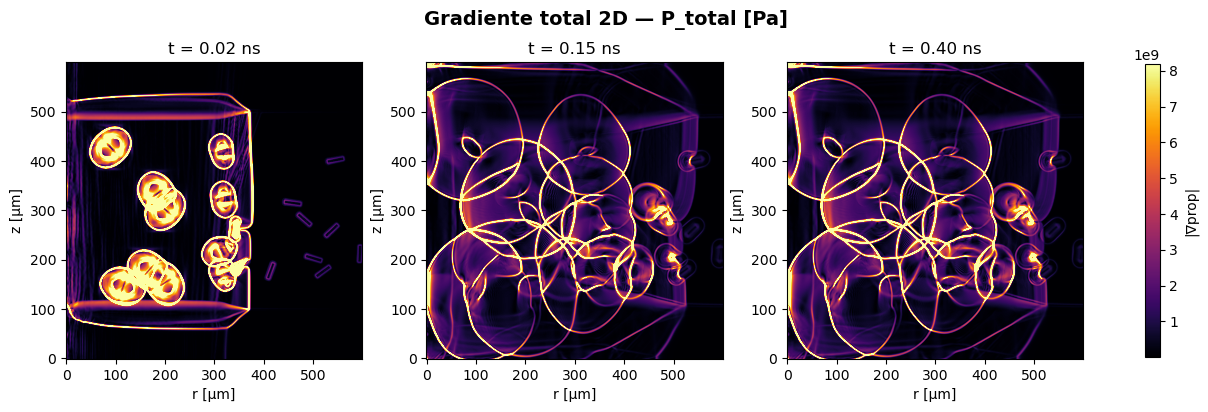

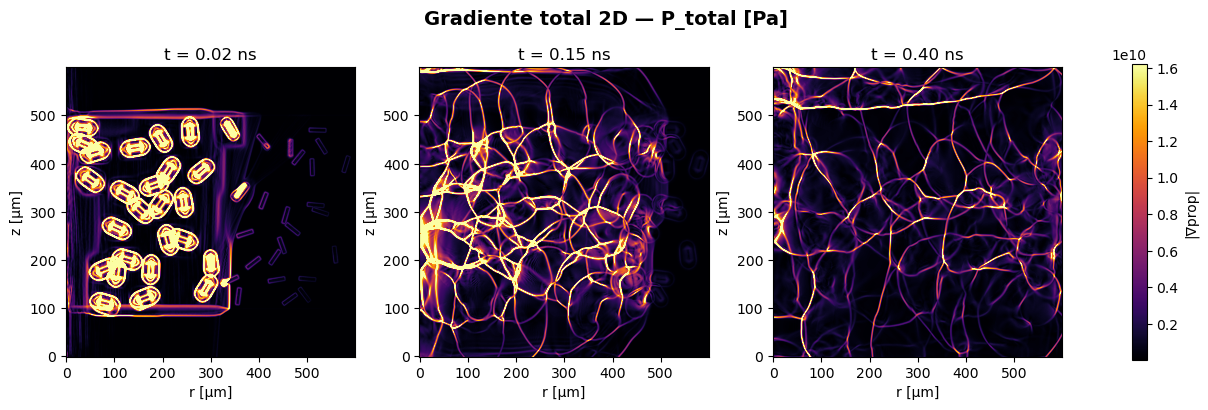

In [26]:
# LD

ruta_hdf5 = [r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_LD.h5", r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_LD.h5"]
indice= 12
tiempos_ns = [0.02 , 0.15, 0.4]

for r in ruta_hdf5:
    ver_gradiente_total_2D_por_tiempos(
        r,
        indice,
        tiempos_ns_objetivo=tiempos_ns
    )

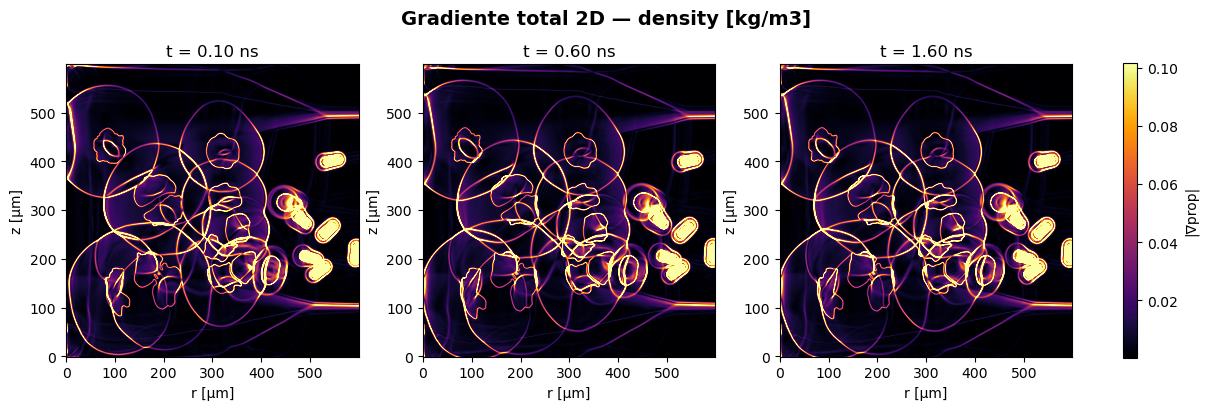

In [ ]:
# HD

ruta_hdf5 = r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_LD.h5"
indice= 5
tiempos_ns = [0.1 , 0.6, 1.6]


ver_gradiente_total_2D_por_tiempos(
    ruta_hdf5,
    indice,
    tiempos_ns_objetivo=tiempos_ns
)

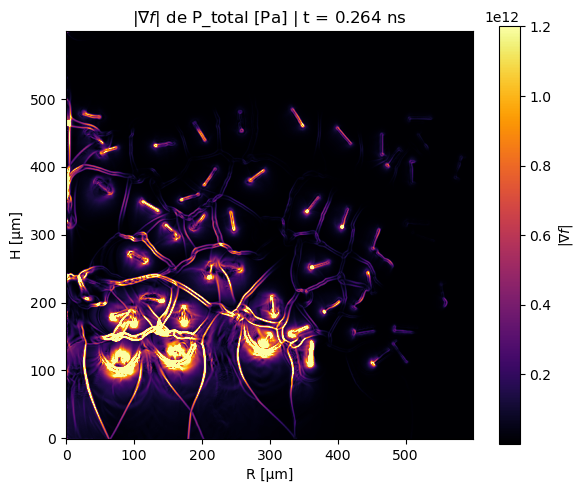

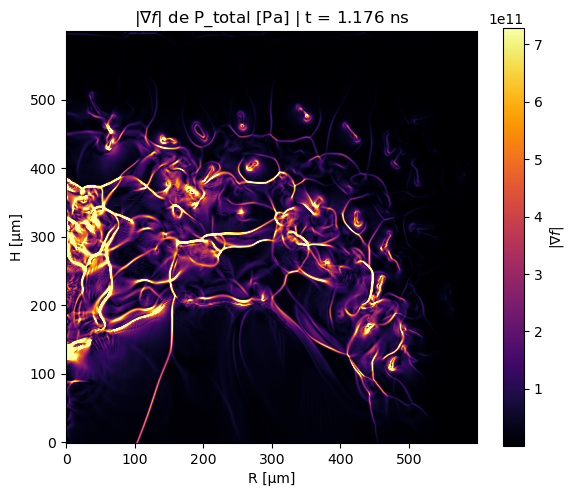

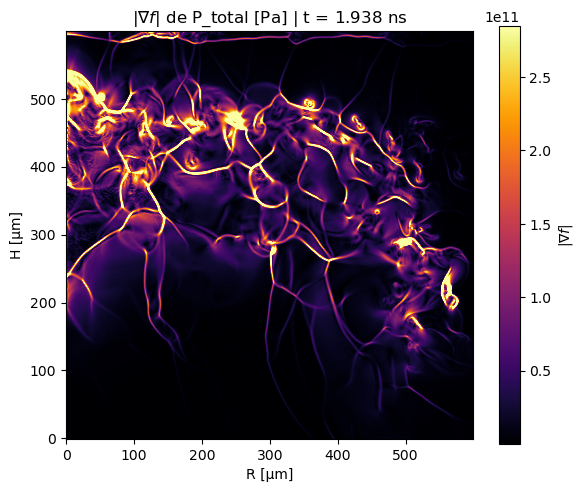

In [12]:
ruta_hdf5 = r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_HD.h5"
indice = 12
t_index = [ 400, 1100, 1380]

for t in t_index:

    ver_gradiente_total_2D_por_indice(
        ruta_hdf5,
        indice,
        t
    )


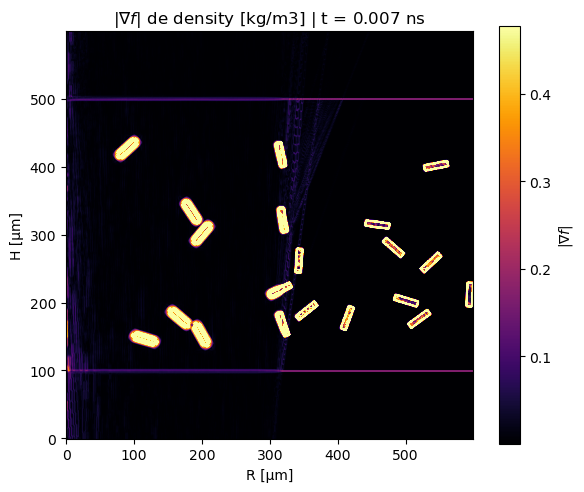

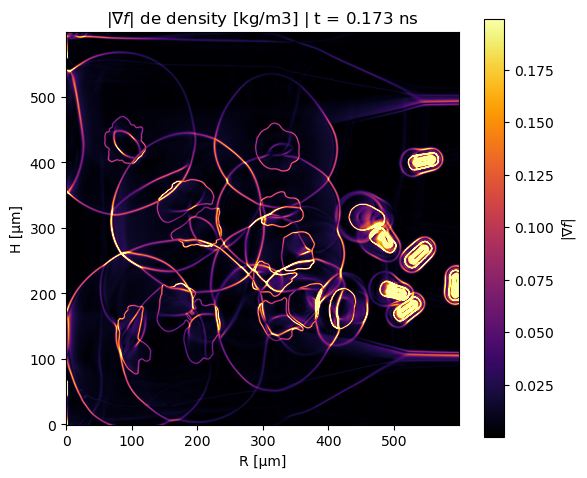

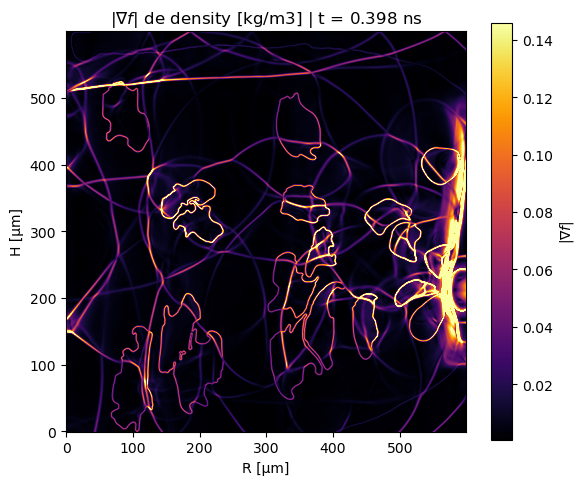

In [18]:
ruta_hdf5 = r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_LD.h5"
indice = 5
t_index = [5, 120, 250]

for t in t_index:
    ver_gradiente_total_2D_por_indice(
        ruta_hdf5,
        indice,
        t
    )

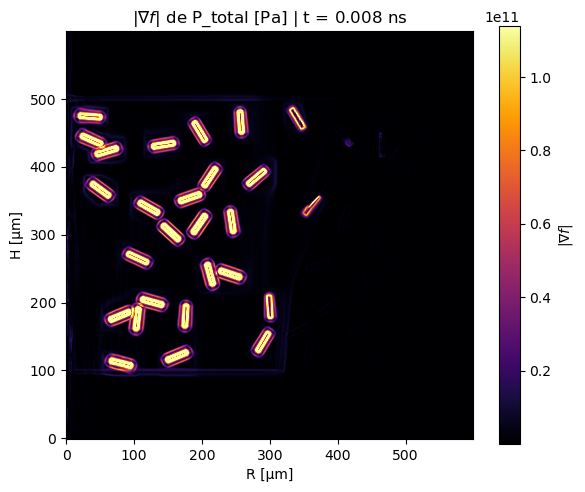

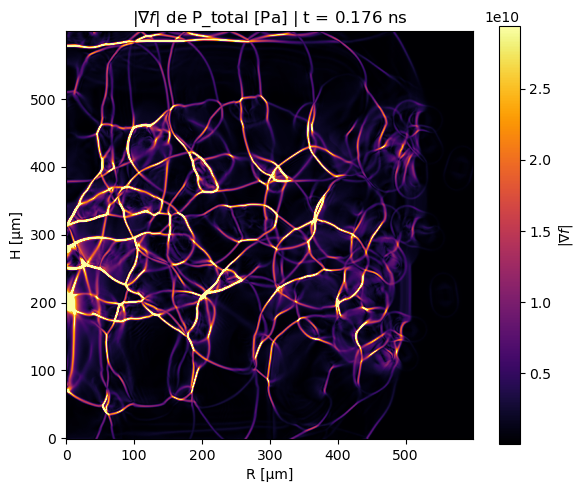

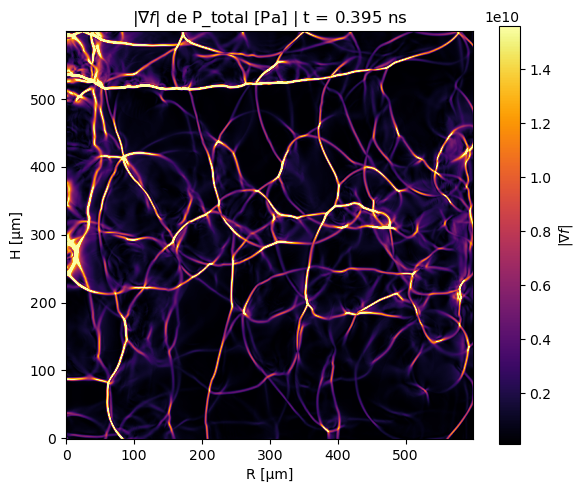

In [21]:
ruta_hdf5 = r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_LD.h5"
indice = 12
t_index = [5, 148, 290]

for t in t_index:
    ver_gradiente_total_2D_por_indice(
        ruta_hdf5,
        indice,
        t
    )